# **교통 표지판 이미지 분류**

- 교통 표지판 이미지 데이터를 분석하고 딥러딩 모델을 통하여 표지판 종류를 예측하는 분류 모델 수행
- 대량의 이미지 데이터를 전 처리하는 과정과 이에 따른 CNN 모델의 성능 변화를 학습

## 데이터 출처
-  https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign



---



In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential


%matplotlib inline



---



# **1. 데이터 분석**

이미지 데이터를 이루고 있는 요소에 대해서 Dataframe를 사용하여 분석 및 확인<br>
<br>
    1-1. 이미지 데이터 정보 파악하기 - Meta<br>
    1-2. 이미지 데이터 정보 파악하기 - Train<br>
    1-3. 이미지 데이터 정보 파악하기 - Test<br>

**이미지 데이터 정보 파악하기 - Meta**

In [3]:
# 이미지 데이터를 읽어오기 위해서 ./data 에 어떠한 파일들이 존재 하는지 확인.

file_list = os.listdir('/content/drive/MyDrive/trafficSign/data')
file_list

# 3개의 폴더와 3개의 csv 파일이 존재.
# 일반적으로 이미지 데이터의 csv 파일이 제공되는 경우, 해당 이미지의 디렉토리 정보가 저장

['Train', 'Train.csv', 'Meta.csv', 'Meta', 'Test.csv', 'Test']

In [4]:
# csv 파일을 dataframe으로 읽어옴.
import pandas as pd

df_Meta = pd.read_csv('/content/drive/MyDrive/trafficSign/data/Meta.csv')
df_Meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/0.png,0,1,0,3.29
1,Meta/1.png,1,1,0,3.29
2,Meta/2.png,2,1,0,3.29


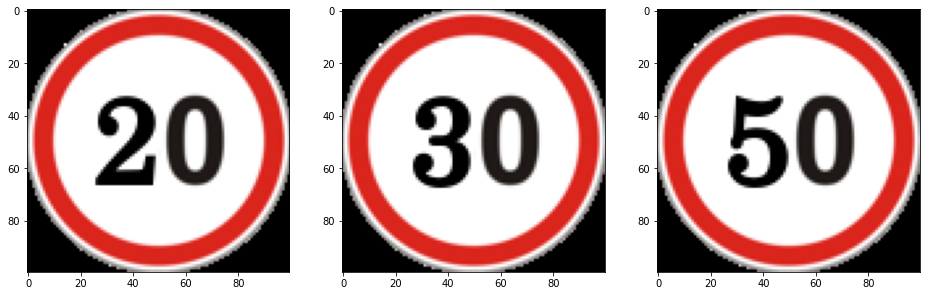

In [8]:
# 이미지 출력
Meta_images = []
Meta_labels = []

plt.figure(figsize=(16,16))
for i in range(len(df_Meta)):
    img = load_img('/content/drive/MyDrive/trafficSign/data/'+df_Meta['Path'][i])
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    Meta_images.append(img)
    Meta_labels.append(df_Meta['ClassId'][i])

**이미지 데이터 정보 파악하기 - Train**

In [9]:
df_Train = pd.read_csv('/content/drive/MyDrive/trafficSign/data/Train.csv')
df_Train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,29,30,5,6,24,25,0,Train/0/00000_00000_00000.png
1,30,30,5,5,25,25,0,Train/0/00000_00000_00001.png
2,30,30,5,5,25,25,0,Train/0/00000_00000_00002.png
3,31,31,5,5,26,26,0,Train/0/00000_00000_00003.png
4,30,32,5,6,25,26,0,Train/0/00000_00000_00004.png
...,...,...,...,...,...,...,...,...
2665,50,51,6,6,45,46,2,Train/2/00002_00040_00025.png
2666,52,52,6,6,47,47,2,Train/2/00002_00040_00026.png
2667,55,55,6,6,50,50,2,Train/2/00002_00040_00027.png
2668,59,58,6,5,53,52,2,Train/2/00002_00040_00028.png




Width와 Height 정보는 이미지의 폭과 높이에 대한 정보로, 다양한 크기가 존재함.

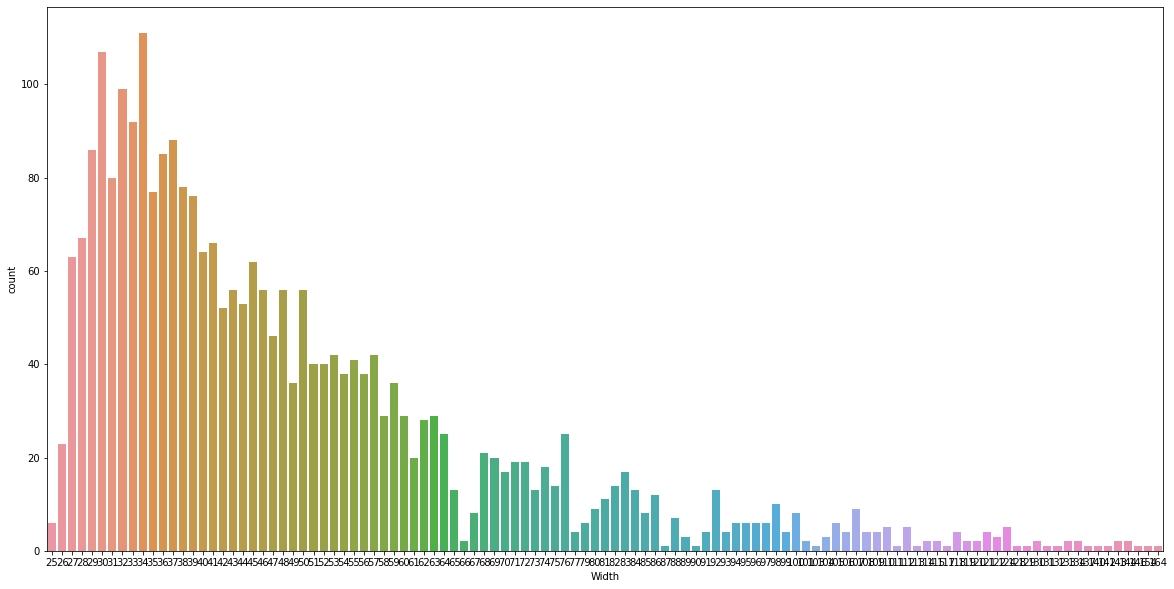

In [10]:
# 크기로 통일을 해야함.
import seaborn as sns

plt.figure(figsize=(20,10))
ax = sns.countplot(x="Width", data=df_Train)

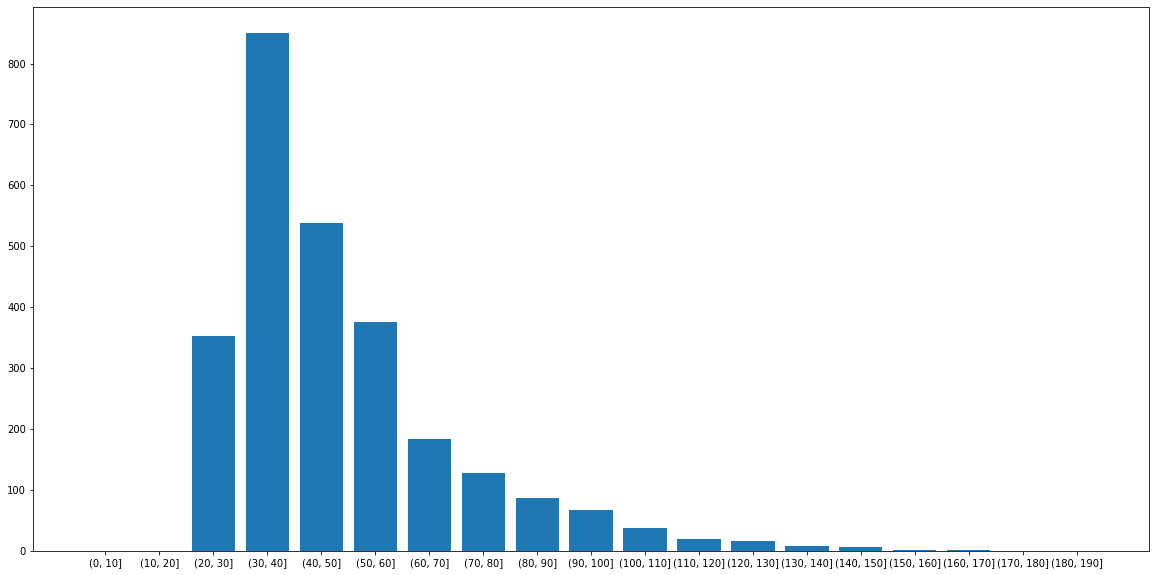

In [11]:
# 위 분포를 보게 되면 30~35의 폭 또는 높이를 갖는 이미지가 제일 많음.

df_cutWidth = pd.cut(df_Train['Width'], np.arange(0,200,10)).value_counts(sort=False)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(df_cutWidth)),df_cutWidth.values)
ax.set_xticks(range(len(df_cutWidth)))
ax.set_xticklabels(df_cutWidth.index)
fig.show()

In [12]:
image_height = 33
image_width = 33
image_channel = 3 # 컬러 이미지이기에 3채널

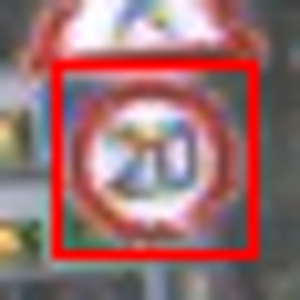

In [14]:
from PIL import Image
from PIL import ImageDraw

img_sample = Image.open('/content/drive/MyDrive/trafficSign/data/'+df_Train['Path'][0])

draw = ImageDraw.Draw(img_sample)
draw.rectangle([df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]], outline="red")
img_sample_resized = img_sample.resize((300,300))
img_sample_resized

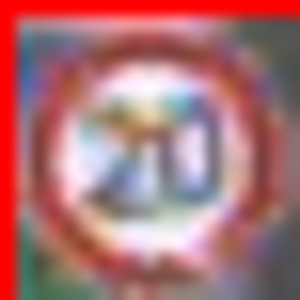

In [15]:
# Roi 데이터를 사용하면 보다 명확하게 표지판 부분만을 crop할 수 있다.
img_sample_crop = img_sample.crop((df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]))
 
# Shows the image in image viewer
img_sample_crop_resized = img_sample_crop.resize((300,300))
img_sample_crop_resized



---



**이미지 데이터 정보 파악하기 - Test**

In [17]:
df_Test = pd.read_csv('/content/drive/MyDrive/trafficSign/data/Test.csv')
df_Test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,42,45,5,5,36,40,1,Test/00001.png
1,59,65,5,6,54,60,1,Test/00024.png
2,58,59,6,6,53,54,2,Test/00034.png
3,37,37,5,6,31,32,2,Test/00067.png
4,45,51,6,6,40,46,1,Test/00076.png
...,...,...,...,...,...,...,...,...
127,32,36,5,6,26,30,1,Test/01021.png
128,75,72,6,6,69,66,1,Test/01029.png
129,61,60,6,5,56,55,2,Test/01035.png
130,54,52,5,5,49,47,2,Test/01037.png




---



# **2. 데이터 전 처리**

**이미지 데이터 읽기**

In [18]:
# 먼저 학습용 이미지를 불러와 Train_images에 array 형태로 저장

image_height = 33
image_width = 33
image_channel = 3

Train_images = []
Train_labels = []

for i in tqdm(range(len(df_Train))):
    img = load_img('/content/drive/MyDrive/trafficSign/data/'+df_Train['Path'][i], target_size = (image_height, image_width))
    img = img_to_array(img)
    Train_images.append(img)

100%|██████████| 2670/2670 [15:58<00:00,  2.79it/s]


In [20]:
Test_images = []
Test_labels = []

for i in tqdm(range(len(df_Test))):
    img = load_img('/content/drive/MyDrive/trafficSign/data/'+df_Test['Path'][i], target_size = (image_height, image_width))
    img = img_to_array(img)
    Test_images.append(img)

100%|██████████| 132/132 [00:45<00:00,  2.90it/s]


**label 데이터 읽기**

In [21]:
Train_labels = df_Train['ClassId'].values
Train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [22]:
Test_labels = df_Test['ClassId'].values
Test_labels

array([1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2,
       2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       0, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2])

**데이터 분리하기**

딥러닝 학습 시, 과적합을 막기 위하여 validation 데이터를 학습용 데이터에서 분리한다.

In [23]:
# validation 데이터 생성
x_train, x_val, y_train, y_val = train_test_split(np.array(Train_images), np.array(Train_labels), test_size=0.4)

In [25]:
# 평가용 데이터도 분리
x_test = np.array(Test_images)
y_test = np.array(Test_labels)



---



# **3. 딥러닝 모델**

**CNN 모델 설정**

In [26]:
model = Sequential([    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(image_height, image_width, image_channel)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.25),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

**학습 수행**

In [27]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [38]:
EPOCHS = 25

# EPOCHS에 따른 성능을 보기 위하여 history 사용
history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_val, y_val), # validation 데이터 사용
                    epochs=EPOCHS, 
                   )

Epoch 1/25
51/51 [==============================] - 3s 57ms/step - loss: 0.8361 - accuracy: 0.5836 - val_loss: 0.8810 - val_accuracy: 0.5225
Epoch 2/25
51/51 [==============================] - 3s 55ms/step - loss: 0.8454 - accuracy: 0.5593 - val_loss: 0.8352 - val_accuracy: 0.5431
Epoch 3/25
51/51 [==============================] - 3s 56ms/step - loss: 0.8204 - accuracy: 0.5780 - val_loss: 0.8599 - val_accuracy: 0.5281
Epoch 4/25
51/51 [==============================] - 3s 56ms/step - loss: 0.8231 - accuracy: 0.5787 - val_loss: 0.7984 - val_accuracy: 0.5590
Epoch 5/25
51/51 [==============================] - 3s 57ms/step - loss: 0.8088 - accuracy: 0.5893 - val_loss: 0.7961 - val_accuracy: 0.5749
Epoch 6/25
51/51 [==============================] - 3s 55ms/step - loss: 0.8326 - accuracy: 0.5624 - val_loss: 0.8081 - val_accuracy: 0.5590
Epoch 7/25
51/51 [==============================] - 3s 55ms/step - loss: 0.8208 - accuracy: 0.5755 - val_loss: 0.7987 - val_accuracy: 0.5674
Epoch 8/25
51

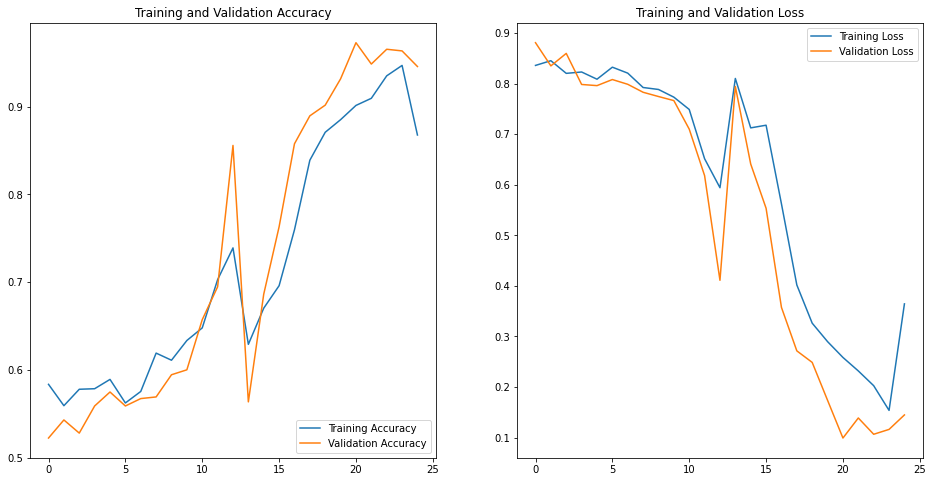

In [39]:
# 학습을 수행하면서 Accuracy와 Loss의 변화를 그래프로 출력

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**모델 성능 평가 및 예측**

In [40]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('test set accuracy: ', test_accuracy)

test set accuracy:  0.9015151262283325


In [41]:
test_prediction = np.argmax(model.predict(x_test), axis=-1)

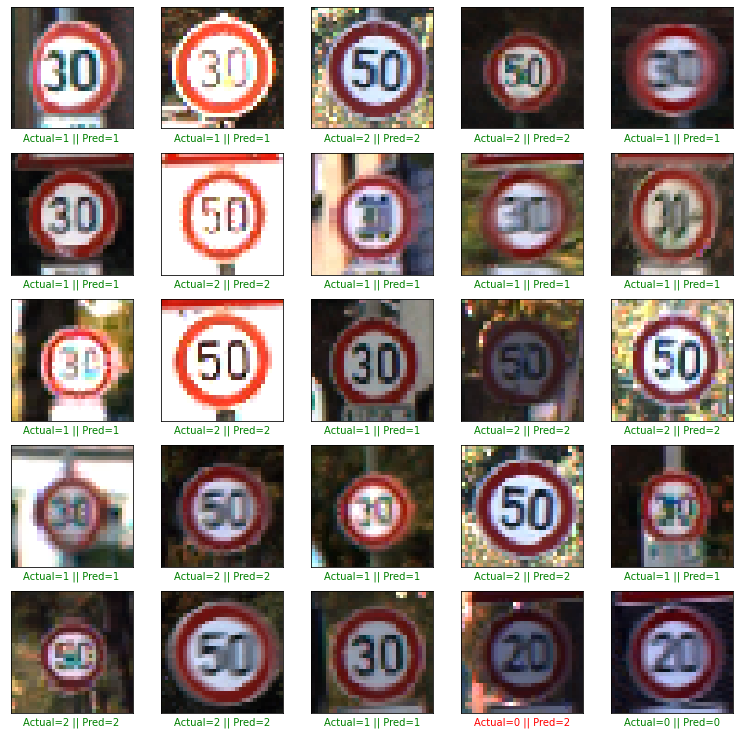

In [42]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = test_prediction[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(array_to_img(x_test[start_index + i]))
plt.show()